# Gradient Boosting Desicion Tree

En las clases anteriores, observamos cómo las mejoras en los algoritmos y las optimizaciones pueden generar avances significativos en la ganancia. Ya hemos logrado un progreso considerable con los modelos de Random Forest. Hoy, daremos un paso aún más grande al explorar los modelos que actualmente están obteniendo los mejores resultados en este tipo de dominios.

Antes que nada, carguemos el entorno de trabajo


In [1]:
%pip install optuna==3.6.1

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle


c:\Users\janic\ml-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
base_path = 'C:\\Users\\janic\\OneDrive\\Documentos\\github\\eyf\\'
dataset_path = base_path + 'datos\\'
modelos_path = base_path + 'modelos\\'
db_path = base_path + 'db\\'
dataset_file = 'competencia_01_con_clase.csv'

ganancia_acierto = 780000
costo_estimulo = 20000

mes_train = [202101,202102,202103]
mes_test = 202104

# agregue sus semillas
semillas = [17,19,23,29,31]

data = pd.read_csv(base_path + dataset_file)

Vamos a asignar pesos a las clases. En unos minutos explicaremos las razones detrás de esta decisión. Mientras tanto, pueden aprovechar el código para ajustar el peso de la clase **BAJA+2** según lo deseen.


In [4]:
data = data.drop(columns=['cprestamos_personales', 'mprestamos_personales'])

data = data.sort_values(["numero_de_cliente", "foto_mes"]).reset_index(drop=True)

cols_lag = [
    "mrentabilidad", "mrentabilidad_annual", "mcomisiones", "mactivos_margen", "mpasivos_margen",
    "mcuenta_corriente", "mcaja_ahorro", "mcaja_ahorro_dolares", "mcuentas_saldo",
    "ctarjeta_debito_transacciones", "mautoservicio", "ctarjeta_visa_transacciones",
    "mtarjeta_visa_consumo", "ctarjeta_master_transacciones", "mtarjeta_master_consumo", "mprestamos_prendarios", "mprestamos_hipotecarios",
    "mplazo_fijo_dolares", "mplazo_fijo_pesos", "minversion1_pesos", "minversion1_dolares",
    "minversion2", "mpayroll", "mpayroll2", "mcuenta_debitos_automaticos",
    "mttarjeta_visa_debitos_automaticos", "mttarjeta_master_debitos_automaticos",
    "mpagodeservicios", "mpagomiscuentas", "mcajeros_propios_descuentos",
    "mtarjeta_visa_descuentos", "mtarjeta_master_descuentos",
    "mcomisiones_mantenimiento", "mcomisiones_otras",
    "mforex_buy", "mforex_sell", "mtransferencias_recibidas", "mtransferencias_emitidas",
    "mextraccion_autoservicio", "mcheques_depositados", "mcheques_emitidos",
    "mcheques_depositados_rechazados", "mcheques_emitidos_rechazados",
    "chomebanking_transacciones", "ctrx_quarter", "cmobile_app_trx"
]

new_cols = pd.DataFrame(index=data.index)

for col in cols_lag:
    grupo = data.groupby("numero_de_cliente")[col]
    new_cols[f"nis_{col}_lag1"] = grupo.shift(1)
    new_cols[f"nis_{col}_lag2"] = grupo.shift(2)
    new_cols[f"nis_{col}_delta_lag1"] = data[col] - new_cols[f"nis_{col}_lag1"]
    new_cols[f"nis_{col}_delta_lag2"] = data[col] - new_cols[f"nis_{col}_lag2"]

data = pd.concat([data, new_cols], axis=1)
data = data.copy() 


C:\Users\janic\AppData\Local\Temp\ipykernel_21500\3771163544.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_cols[f"nis_{col}_lag1"] = grupo.shift(1)
C:\Users\janic\AppData\Local\Temp\ipykernel_21500\3771163544.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_cols[f"nis_{col}_lag2"] = grupo.shift(2)
C:\Users\janic\AppData\Local\Temp\ipykernel_21500\3771163544.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

In [5]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

Además, como se mencionó en la clase pasada, comenzaremos a experimentar con nuevas clases para ajustar el modelo. En particular, sumaremos la clase **BAJA+1**, que es estructuralmente muy similar a **BAJA+2**, para aumentar los casos positivos. Luego, compararemos los resultados obtenidos con los de la clase con la que hemos estado trabajando hasta ahora.

In [6]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

Y trabajaremos como es habitual en las últimas clases, con **Febrero** para entrenar y **Abril** para medir, con el fin de realizar *backtesting*

In [7]:
#train_data = data[data['foto_mes'] == mes_train]
train_data = data[data['foto_mes'].isin(mes_train)]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_binaria2 = test_data['clase_binaria2']

w_test = test_data['clase_peso']

Y preparamos el *dataset* para poder usar el **rf** de una clase anterior.

In [8]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

# Parámetros del modelos.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

LGBM necesita su propio tipo de Datasets:

In [9]:
train_data1 = lgb.Dataset(X_train, label=y_train_binaria1, weight=w_train)
train_data2 = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train)

A continuación, compararemos las dos clases. Utilizaremos para medir la calidad de las clases (y de los parámetros), la función **cv** que viene *out-of-the-box*

Y vizualizamos los resultados de ambas ejecuciones:

No parece haber un diferencia sustancial. **Pero** solo hicimos una ejecución. De tarea prueba esta estrategia correctamente.

A continuación, procederemos a optimizar **LightGBM** utilizando la librería **Optuna**. Cabe destacar que las optimizaciones que realizaremos son básicas y están diseñadas para ejecutarse en pocos minutos. Será su responsabilidad ampliar tanto el rango de búsqueda como el tiempo de optimización para obtener un modelo más competitivo.


In [10]:

def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 100),
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3), # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1000),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=100, # modificar, subit y subir... y descomentar la línea inferior
        # early_stopping_rounds= int(50 + 5 / learning_rate),
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


storage_name = "sqlite:///" + db_path + "optimization_lgbm_ultimo_intento.db"
study_name = "exp_301_lgbm"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2025-11-02 18:40:43,305] Using an existing study with name 'exp_301_lgbm' instead of creating a new one.


In [11]:
# study.optimize(objective, n_trials=15) # subir subir

Analizamos los resultados as usual

In [12]:
optuna.visualization.plot_optimization_history(study)

In [13]:
plot_param_importances(study)

El **learning rate** es un parámetro que tiene que ir acompañado por más árboles.

In [14]:
plot_slice(study)

In [15]:
plot_contour(study)

In [16]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [17]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(best_iter)


num_leaves = study.best_trial.params['num_leaves']
learning_rate = study.best_trial.params['learning_rate']
min_data_in_leaf = study.best_trial.params['min_data_in_leaf']
feature_fraction = study.best_trial.params['feature_fraction']
bagging_fraction = study.best_trial.params['bagging_fraction']

# num_leaves = 96
# learning_rate = 0.10786251291535232
# min_data_in_leaf = 844
# feature_fraction = 0.817823789674196
# bagging_fraction = 0.9701924741567449

print("num_leaves:", study.best_trial.params['num_leaves'])
print("learning_rate:", study.best_trial.params['learning_rate'])
print("min_data_in_leaf:", study.best_trial.params['min_data_in_leaf'])
print("feature_fraction:", study.best_trial.params['feature_fraction'])
print("bagging_fraction:", study.best_trial.params['bagging_fraction'])


100
num_leaves: 75
learning_rate: 0.09050296119713902
min_data_in_leaf: 406
feature_fraction: 0.420671602155407
bagging_fraction: 0.1153395502686529


In [18]:
print(len(X_train), len(y_train_binaria2), len(w_train))


486791 486791 486791


In [19]:
#best_iter = study.best_trial.user_attrs["best_iter"]
best_iter = 98
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,
    'min_data_in_leaf': min_data_in_leaf,
    'feature_fraction': feature_fraction,
    'bagging_fraction': bagging_fraction,
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Mejor cantidad de árboles para el mejor model 98


Observamos la variables más importantes para el modelo:

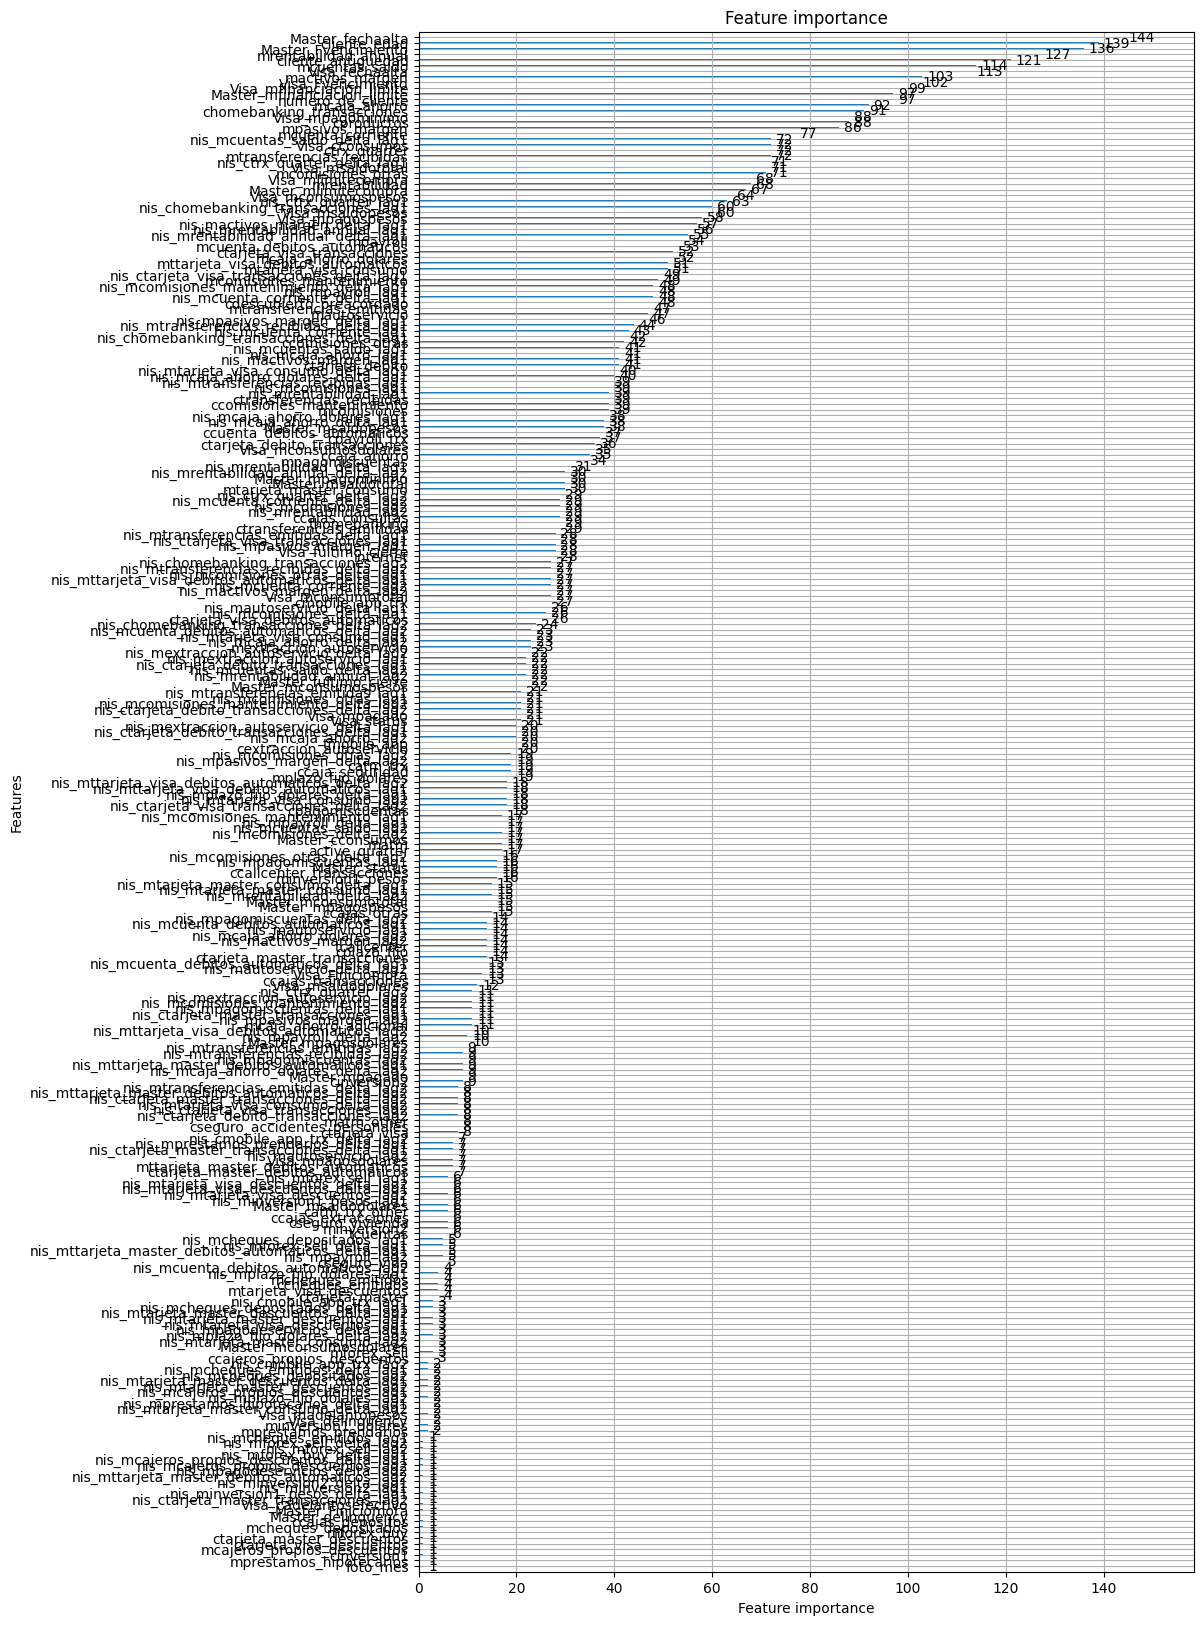

In [20]:
lgb.plot_importance(model, figsize=(10, 20))
plt.show()


Y si queremos tener las variables más importantes en forma de *Dataframe*:

In [21]:

nis_cols = [c for c in data.columns if c.startswith('nis_')]

importancias_nis = pd.Series(model.feature_importance(), index=model.feature_name())
importancias_nis = importancias_nis[importancias_nis.index.isin(nis_cols)]

importancias_nis.sort_values().head(20)




nis_mpayroll2_delta_lag2                      0
nis_minversion1_pesos_delta_lag2              0
nis_minversion1_pesos_lag2                    0
nis_mforex_buy_delta_lag2                     0
nis_mplazo_fijo_pesos_delta_lag2              0
nis_mforex_buy_lag2                           0
nis_mforex_buy_lag1                           0
nis_mplazo_fijo_pesos_delta_lag1              0
nis_mplazo_fijo_pesos_lag2                    0
nis_mplazo_fijo_pesos_lag1                    0
nis_mprestamos_hipotecarios_delta_lag2        0
nis_mprestamos_hipotecarios_lag2              0
nis_mprestamos_hipotecarios_lag1              0
nis_mprestamos_prendarios_delta_lag2          0
nis_mprestamos_prendarios_lag2                0
nis_mprestamos_prendarios_lag1                0
nis_mcajeros_propios_descuentos_delta_lag2    0
nis_mpagodeservicios_lag1                     0
nis_mpagodeservicios_lag2                     0
nis_minversion1_dolares_lag2                  0
dtype: int32

In [22]:
importances = model.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 0]


,feature,importance
125,Master_fechaalta,144
5,cliente_edad,139
111,Master_Fvencimiento,136
8,mrentabilidad_annual,127
6,cliente_antiguedad,121
...,...,...
230,nis_minversion1_pesos_delta_lag1,1
150,Visa_cadelantosefectivo,1
35,mprestamos_hipotecarios,1
205,nis_ctarjeta_master_transacciones_lag2,1


Para guardar el modelo para poder utilizarlo más adelante, no es necesario guardarlo como *pickle*, la librería nos permite guardarlo en formato texto

In [23]:
model.save_model(modelos_path + 'lgb_first.txt')

Y recuperar el mismo desde ese formato

In [24]:
model = lgb.Booster(model_file=modelos_path + 'lgb_first.txt')

Para realizar nuestra habitual comparación de modelos, partiremos desde el mejor que obtuvimos hasta ahora, el **rf**. Para este fin cargaremos el *binario* que ajustamos un par de clases atrás:

In [25]:
# filename_rf_1000 = modelos_path + 'exp_206_random_forest_model_1000.sav'
# model_rf_1000 = pickle.load(open(filename_rf_1000, 'rb'))

Y sobre ambos modelos obtenemos la predicción de **Abril**

In [26]:
# y_pred_rf = model_rf_1000.predict_proba(Xif)
# y_pred_rf = y_pred_rf[:,1] # adaptamos la salida para que sea homogénea con el LGBM

y_pred_lgm = model.predict(X_test)

Finalmente medimos las ganancias de ambos

In [27]:
def ganancia_prob(y_pred, y_true, prop = 1):
  ganancia = np.where(y_true == 1, ganancia_acierto, 0) - np.where(y_true == 0, costo_estimulo, 0)
  return ganancia[y_pred >= 0.025].sum() / prop

print("Ganancia LGBM 1:", ganancia_prob(y_pred_lgm, y_test_binaria1))
print("Ganancia LGBM 2:", ganancia_prob(y_pred_lgm, y_test_binaria2))


Ganancia LGBM 1: 329860000.0
Ganancia LGBM 2: 961860000.0


Vemos un nuevo salto, tan alto como el del árbol al rf. Será simplemente suerte? veamos que sucede sobre múltiples **LDB**

Otra vez se observa la superioridad del **LGBM**. Veamos que hubiera pasado si elegíamos el mejor del público

Observamos que en 50 **LDBs** solo en un público ganó un **rf**, sin embargo en el 100% de los casos, en el privado ganó un **lgbm**. Asombroso.

Pero el alumno atento, vio que para la selección del mejor modelo no se utilizó ningún punto de corte. Podrá pasar que el mejor punto de corte en entrenamiento, no sea el mejor para un mes en el futuro?

Veamos para esto la curva de ganancia en función de los puntos de corte

In [28]:
ganancia = np.where(y_test_binaria2 == 1, ganancia_acierto, 0) - np.where(y_test_binaria2 == 0, costo_estimulo, 0)

idx = np.argsort(y_pred_lgm)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm[idx]

ganancia_cum = np.cumsum(ganancia)


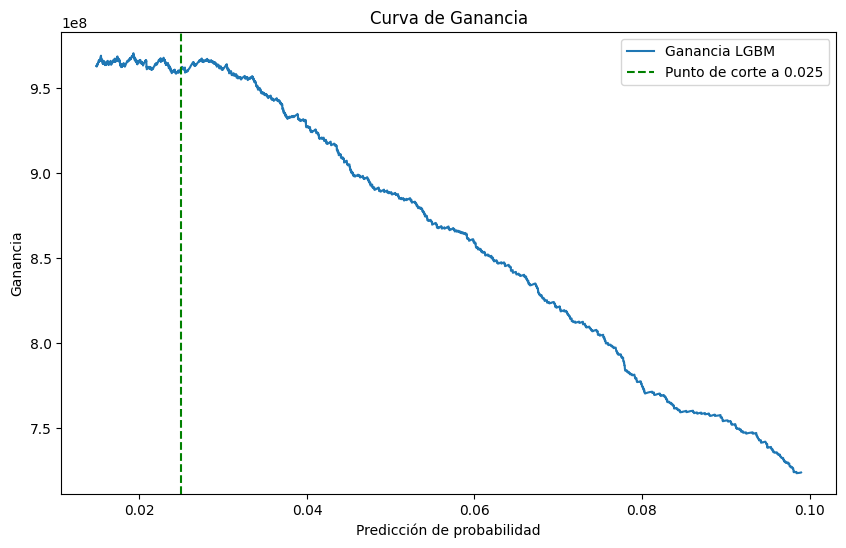

In [29]:
piso_envios = 4000
techo_envios = 20000

plt.figure(figsize=(10, 6))
plt.plot(y_pred_lgm[piso_envios:techo_envios], ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.title('Curva de Ganancia')
plt.xlabel('Predicción de probabilidad')
plt.ylabel('Ganancia')
plt.axvline(x=0.025, color='g', linestyle='--', label='Punto de corte a 0.025')
plt.legend()
plt.show()


In [30]:
idx_max = np.argmax(ganancia_cum[piso_envios:techo_envios])
prob_max = y_pred_lgm[piso_envios:techo_envios][idx_max]
ganancia_max = ganancia_cum[piso_envios:techo_envios][idx_max]

print(f"Máxima ganancia: {ganancia_max:.2f} en probabilidad {prob_max:.4f}")


Máxima ganancia: 970600000.00 en probabilidad 0.0193


Vaya! realmente nuestro teórico mejor punto de corte no es el que mayor ganancia genera. Es hora de cambiar el enfoque.

En vez de mirar el punto de corte, empezaremos a pensar en cuál es la cantidad máxima de clientes que se deben estimular. Si cambiamos a esto, veremos que el gráfico anterior se ve así

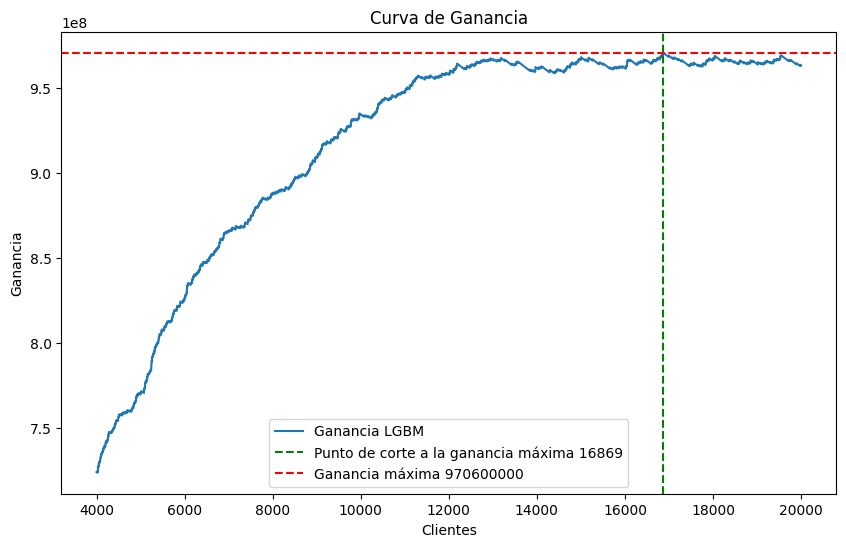

In [31]:
piso_envios = 4000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


In [33]:
# train_data = data[data['foto_mes'].isin([202102,202101,202103, 202104])]
# y_train_binaria2 = train_data['clase_binaria2']
# w_train = train_data['clase_peso']
# X_train_con_abril = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)


# train_data_con_abril = lgb.Dataset(X_train_con_abril,
#                           label=y_train_binaria2,
#                           weight=w_train)

# model = lgb.train(params,
#                   train_data_con_abril,
#                   num_boost_round=best_iter)


# # Load data for 202106
# data_202106 = data[data['foto_mes'] == 202106].copy()

# # Preprocess the data (same as training and testing data)
# X_202106 = data_202106.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
# # Removed imputation: X_202106_imputed = imp_mean.transform(X_202106)

# # Make predictions using the trained LightGBM model (from cell bwyUriQksZAM)
# # Using X_202106 directly, assuming no missing values or LightGBM is configured to handle them
# y_pred_202106 = model.predict(X_202106)

# # --- Display summary statistics of predictions ---
# print("\nSummary statistics of predicted probabilities:")
# print(pd.Series(y_pred_202106).describe())
# # -------------------------------------------------


# # Apply a fixed threshold of 0.025
# fixed_threshold = 0.0233
# data_202106['predicted'] = np.where(y_pred_202106 >= fixed_threshold, 1, 0)

# # Create the output DataFrame with numero_de_cliente and predicted columns
# output_df = data_202106[['numero_de_cliente', 'predicted']]

# # Count the number of predicted positives and print it
# num_predicted_positives = output_df['predicted'].sum()
# print(f"\nNumber of predicted positives in 202106 with threshold {fixed_threshold}: {num_predicted_positives}")

# # Save the predictions to a CSV file
# output_path = base_path + 'predicciones_202106_01.csv'
# output_df.to_csv(output_path, index=False)

# print(f"Predictions saved to: {output_path}")


In [34]:
# import lightgbm as lgb
# import numpy as np
# import pandas as pd

# # === Parámetros ===
# grupos_entrenamiento = [
#     [202101, 202102],  # Grupo 1
#     [202103, 202104]   # Grupo 2
# ]
# mes_prediccion = 202106
# threshold = 0.03  # punto de corte fijo

# # --- Preparar data de predicción ---
# data_202106 = data[data['foto_mes'] == mes_prediccion].copy()
# X_202106 = data_202106.drop(
#     ['clase_ternaria', 'clase_peso', 'clase_binaria1', 'clase_binaria2'],
#     axis=1
# )

# # Diccionario para guardar las predicciones binarias de cada modelo
# predicciones_binarias = {}

# # --- Entrenar un modelo por cada grupo de meses ---
# for i, grupo in enumerate(grupos_entrenamiento, start=1):
#     print(f"\nEntrenando modelo con datos de {grupo}...")

#     # Unir los meses del grupo
#     train_data = data[data['foto_mes'].isin(grupo)]

#     y_train_binaria2 = train_data['clase_binaria2']
#     w_train = train_data['clase_peso']
#     X_train = train_data.drop(
#         ['clase_ternaria', 'clase_peso', 'clase_binaria1', 'clase_binaria2'],
#         axis=1
#     )

#     # Crear dataset LightGBM
#     train_lgb = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train)

#     # Entrenar modelo
#     model = lgb.train(params, train_lgb, num_boost_round=best_iter)

#     # Predecir sobre junio 2021
#     y_pred = model.predict(X_202106)

#     # Aplicar el punto de corte 0.025
#     predicciones_binarias[f'grupo_{i}'] = (y_pred >= threshold).astype(int)

#     print(f"Grupo {i}: {sum(predicciones_binarias[f'grupo_{i}'])} clientes predichos como 1 (de {len(y_pred)})")

# # --- Combinar predicciones ---
# predicciones_df = pd.DataFrame(predicciones_binarias)
# predicciones_df['numero_de_cliente'] = data_202106['numero_de_cliente'].values

# # Si al menos un modelo lo marcó como 1, queda 1
# predicciones_df['predicted'] = (
#     (predicciones_df == 1).any(axis=1)
# ).astype(int)

# # --- Crear archivo final ---
# output_df = predicciones_df[['numero_de_cliente', 'predicted']]
# num_predicted_positives = output_df['predicted'].sum()

# # Guardar CSV
# output_path = base_path + 'predicciones_202106_combinadas_grupos_fixed025.csv'
# output_df.to_csv(output_path, index=False)

# print(f"\n✅ Archivo final guardado en: {output_path}")
# print(f"👉 Clientes predichos como 1: {num_predicted_positives}")


In [ ]:

seeds = [1234, 2025, 9876, 777, 5555]  
ganancia_acierto = 780000
costo_estimulo = 20000
fixed_threshold = 0.026
meses_entrenamiento = [ 202101,202102, 202103, 202104]
mes_prediccion = 202106

# --- Preparar data de entrenamiento ---
train_data = data[data['foto_mes'].isin(meses_entrenamiento)].copy()
y_train = train_data['clase_binaria2']
w_train = train_data['clase_peso']
X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1', 'clase_binaria2'], axis=1)

# --- Preparar data de predicción ---
data_202106 = data[data['foto_mes'] == mes_prediccion].copy()
X_202106 = data_202106.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1', 'clase_binaria2'], axis=1)

# --- Dataset de LightGBM ---
train_lgb = lgb.Dataset(X_train, label=y_train, weight=w_train)

# --- Predicciones por seed ---
predicciones_por_seed = []

for seed in seeds:
    print(f"\n🌱 Entrenando modelo con seed = {seed}")

    params_seed = params.copy()
    params_seed['seed'] = seed
    params_seed['feature_fraction_seed'] = seed
    params_seed['bagging_seed'] = seed

    model = lgb.train(
        params_seed,
        train_lgb,
        num_boost_round=best_iter,
    )

    y_pred = model.predict(X_202106)
    predicciones_por_seed.append(y_pred)

# --- Promediar las probabilidades ---
preds_promedio = np.mean(predicciones_por_seed, axis=0)

# --- Aplicar punto de corte al promedio ---
data_202106['predicted'] = np.where(preds_promedio >= fixed_threshold, 1, 0)

# --- Crear DataFrame final ---
output_df = data_202106[['numero_de_cliente', 'predicted']]
num_predicted_positives = output_df['predicted'].sum()

# --- Guardar CSV ---
output_path = base_path + 'predicciones_202106_promedio_seeds.csv'
output_df.to_csv(output_path, index=False)

# --- Mostrar resultados ---
print(f"\n✅ Archivo final guardado en: {output_path}")
print(f"👉 Clientes predichos como 1 (usando promedio y threshold {fixed_threshold}): {num_predicted_positives:,}")

# --- (Opcional) Mostrar estadísticas del promedio de probabilidades ---
print("\n📊 Estadísticas del promedio de probabilidades:")
print(pd.Series(preds_promedio).describe())



🌱 Entrenando modelo con seed = 1234

🌱 Entrenando modelo con seed = 2025

🌱 Entrenando modelo con seed = 9876

🌱 Entrenando modelo con seed = 777

🌱 Entrenando modelo con seed = 5555

✅ Archivo final guardado en: C:\Users\janic\OneDrive\Documentos\github\eyf\predicciones_202106_promedio_seeds.csv
👉 Clientes predichos como 1 (usando promedio y threshold 0.026): 13,712

📊 Estadísticas del promedio de probabilidades:
count    164313.000000
mean          0.011075
std           0.042894
min           0.000035
25%           0.000358
50%           0.001113
75%           0.004855
max           0.974961
dtype: float64


In [ ]:
def calcular_ganancia(y_pred_prob, threshold, ganancia_acierto, costo_estimulo):
    """
    Calcula la ganancia total esperada dado un vector de probabilidades
    y un threshold de decisión.
    """
    predicted_positives = y_pred_prob >= threshold

    ganancia_total = np.sum(predicted_positives * (ganancia_acierto * y_pred_prob - costo_estimulo))
    
    return ganancia_total

threshold = 0.026
ganancia = calcular_ganancia(preds_promedio, threshold, ganancia_acierto, costo_estimulo)
print(f"💰 Ganancia esperada total para threshold {threshold}: ${ganancia:,.0f}")


thresholds = np.arange(0.01, 0.091, 0.001)  # de 0.01 a 0.09 con paso 0.001
ganancias_por_threshold = []

for t in thresholds:
    g = calcular_ganancia(preds_promedio, t, ganancia_acierto, costo_estimulo)
    ganancias_por_threshold.append((t, g))

ganancias_df = pd.DataFrame(ganancias_por_threshold, columns=['threshold', 'ganancia'])
print("\n📊 Ganancia por distintos thresholds:")
print(ganancias_df)


max_idx = ganancias_df['ganancia'].idxmax()
mejor_threshold = ganancias_df.loc[max_idx, 'threshold']
max_ganancia = ganancias_df.loc[max_idx, 'ganancia']

print(f"🏆 Ganancia máxima: ${max_ganancia:,.0f} alcanzada con threshold = {mejor_threshold:.4f}")


💰 Ganancia esperada total para threshold 0.026: $798,215,665

📊 Ganancia por distintos thresholds:
    threshold      ganancia
0       0.010  7.030367e+08
1       0.011  7.213448e+08
2       0.012  7.358804e+08
3       0.013  7.487632e+08
4       0.014  7.591797e+08
..        ...           ...
76      0.086  6.496630e+08
77      0.087  6.475278e+08
78      0.088  6.451151e+08
79      0.089  6.430552e+08
80      0.090  6.402662e+08

[81 rows x 2 columns]
🏆 Ganancia máxima: $798,215,665 alcanzada con threshold = 0.0260
